# Compare tau decay distributions between Tauola and IceCube simulations

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../utils/")
from hepmc_io import load_hepmc 
from collections import Counter

## Load decays

In [28]:
decay_products = load_hepmc("../data/tauola_output_genie_e5.dat").groupby("event_num").nth[3:].sort_values("event_num")
decay_products_nopol = pd.read_csv("../data/geant4_output_e5.csv").sort_values("event_num")

0


In [29]:
decay_products

,event_num,pdg,E,px,py,pz
3,4,16,1.132845,0.439469,-0.681560,0.790937
4,4,-211,2.542037,-0.439625,0.607542,2.424891
8,15,16,1.864992,-0.042088,-0.634777,1.753106
9,15,-211,0.190599,-0.051441,-0.118041,0.016393
10,15,111,1.259576,-0.014008,0.716687,1.026879
...,...,...,...,...,...,...
33722,99981,16,2.744785,-0.113223,0.281086,2.727988
33729,99995,111,0.340267,0.022112,0.123341,0.286120
33730,99995,111,1.393434,0.190467,0.342201,1.330437
33728,99995,16,2.105461,-0.547017,-0.051665,2.032479


In [30]:
decay_products_nopol

,event_num,pdg,E,px,py,pz
0,0,-211,2.146640,0.471600,-0.772368,1.941550
50,0,16,1.524980,-0.470983,0.699429,1.270650
65,1,-211,0.315613,0.260604,0.039485,0.103239
64,1,16,2.610770,-0.686313,-0.095131,2.517150
53,1,111,0.376114,0.303569,0.016122,0.175581
...,...,...,...,...,...,...
15939,5414,16,1.128300,-0.661300,-0.147522,0.902203
15885,5414,-211,1.148000,0.335387,-0.163792,1.076620
15945,5415,111,1.828820,-0.298557,-0.272463,1.778480
16016,5415,-211,0.866230,-0.585862,0.153265,0.603449


## Compare Geant4 decay products with Tauola decay products

In [31]:
def get_particle_property(decay_products: pd.DataFrame, pdg: int, prop: str) -> tuple[pd.Series, pd.Series]:
    nutau_e = decay_products.query("pdg == 16")[prop]
    anti_nutau_e = decay_products.query("pdg == -16")[prop]
    return nutau_e, anti_nutau_e


def compare_histos(nutau, anti_nutau, nutau_nopol, anti_nutau_nopol, bins, density=None, **kwargs):
    fig, axs = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, layout="constrained")

    for ax, label, lists, in zip(axs, ("Neutrino", "Anti-neutrino"), ((nutau, nutau_nopol), (anti_nutau, anti_nutau_nopol))):
        for energies, particle_type in zip(lists, ("polarized", "unpolarized")):
            ax.hist(energies, bins=bins, label=f"{label} {particle_type}", alpha=0.5, density=density)
            # ax.set_title(f"{label} {particle_type}")
            
    for ax in axs.flat:
        ax.set(**kwargs, ylabel="Density of number of neutrinos")
        ax.grid(True, alpha=0.5)
        ax.legend(fontsize="large")

    return fig, axs

/home/simon/miniconda3/envs/cern-skhep/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/simon/miniconda3/envs/cern-skhep/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: xlabel='E [GeV]', ylabel='Density of number of neutrinos'>,
        <Axes: xlabel='E [GeV]', ylabel='Density of number of neutrinos'>],
       dtype=object))

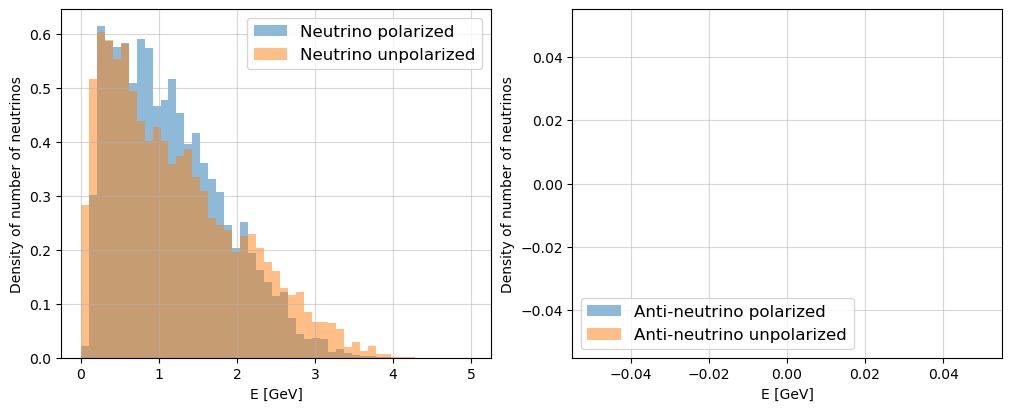

In [32]:
nutau, anti_nutau = get_particle_property(decay_products, 16, "E")
nutau_nopol, anti_nutau_nopol = get_particle_property(decay_products_nopol, 16, "E")

compare_histos(nutau, anti_nutau, nutau_nopol, anti_nutau_nopol, bins=np.linspace(0, 5, 50), xlabel="E [GeV]", density=True)

When viewing the distribution of all events (regardless of decay mode) and the neutrino energy in these cases, there is a slight shift. In the polarized simulations, the neutrinos typically have a lower energy that in the unpolarized case. This would mean that IceCube simulations using the unpolarized simulations underestimate the energy deposited in the detector, i.e., overestimate the missing energy.

## Pion momentum fraction
See Fig. 2 in the DUNE paper

In [33]:
def is_pion_nutau_event(event: pd.DataFrame) -> bool:
    return (event["pdg"] == -211).any() and (event["pdg"] == 16).any() and (event.shape[0] == 2)

# Only select events that decay to a pion and a neutrino (211 and 16)
pion_neutrino_events = (
    decay_products
    .groupby("event_num")
    .filter(is_pion_nutau_event)
)

pion_neutrino_events_nopol = (
    decay_products_nopol
    .groupby("event_num")
    .filter(is_pion_nutau_event)
)

In [42]:
def pion_momentum_fraction(decay_products):
    # Calculate the momentum fraction of the pion (row 3-4) relative to the tau (row 2)
    pion_momentum = (
        decay_products
        .query("pdg.abs() == 211")
        .loc[:, "px":"pz"]
        .pow(2)
        .sum(axis=1)
        .pow(0.5)
    )

    decay_products = decay_products.copy()
    decay_products.loc[:, "P"] = decay_products.loc[:, "px":"pz"].pow(2).sum(axis=1).pow(0.5)
    
    tau_momentum = (
        decay_products
        .groupby("event_num")
        ["P"].sum()
    )
    return pion_momentum.values / tau_momentum.values


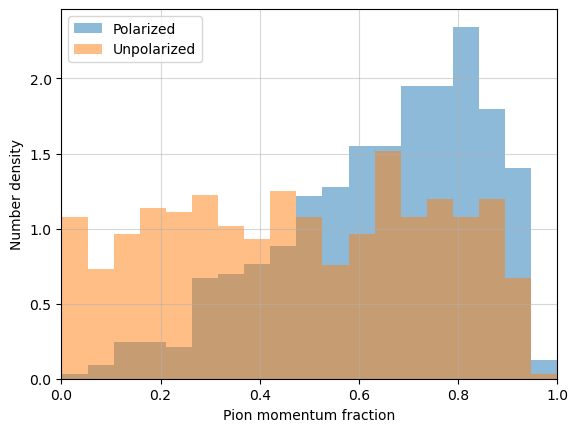

In [43]:
# Plot the momentum fraction as a histogram from 0 to 1
fig, ax = plt.subplots()
ax.hist(pion_momentum_fraction(pion_neutrino_events), bins=np.linspace(0, 1, 20), label="Polarized", alpha=0.5, density=True)
ax.hist(pion_momentum_fraction(pion_neutrino_events_nopol), bins=np.linspace(0, 1, 20), label="Unpolarized", alpha=0.5, density=True)
ax.set(xlim=(0, 1), xlabel="Pion momentum fraction", ylabel="Number density")
ax.grid(True, alpha=0.5)
ax.legend()

We see a clear difference between the decay using Tauola with real polarization given by GENIE and the unpolarized decay by Geant4.
A similar difference would likely be seen for the IceCube simulations.